**Write the names of all group members (max. 5 members)**:
- Lucas, Gimeno
- Matteo, Bodmer
- Nils, Johnson
- Jonas, Isler
- Haiyen, Van

When submitting your work, please follow closely the template below.

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Exercise 1 (Poisson GLM)

### Question 1.a

In [2]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
data = pd.read_csv("freMTPL2freq.csv", delimiter=";")
data.columns = data.columns.str.strip()

# comma to dot
data = data.applymap(lambda x: str(x).replace(",", ".") if isinstance(x, str) else x)

numeric_features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
categorical_features = ["VehBrand", "VehGas", "Region"]

for col in numeric_features+["Exposure"]:
    data[col] = data[col].astype(float)

data[numeric_features] = data[numeric_features].astype(float)

print(data.head())
print(data.dtypes)

features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]
target = "ClaimNb"
exposure = "Exposure"

data["Frequency"] = data[target] / data[exposure]

   VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region  \
0       4.0     9.0     23.0       100.0       B6  Regular   7887.0    R31   
1       4.0     6.0     26.0       100.0       B6  Regular   2308.0    R31   
2       4.0     6.0     26.0       100.0       B6  Regular   2308.0    R31   
3       7.0     4.0     44.0        50.0       B6  Regular     37.0    R94   
4       5.0     2.0     29.0        90.0       B6  Regular    335.0    R91   

   Exposure  ClaimNb  
0      0.76        0  
1      0.74        0  
2      0.11        0  
3      0.83        0  
4      0.69        0  
VehPower      float64
VehAge        float64
DrivAge       float64
BonusMalus    float64
VehBrand       object
VehGas         object
Density       float64
Region         object
Exposure      float64
ClaimNb         int64
dtype: object


In [3]:
# Train-test split
#(90% training and 10% testing)

X = data[features]
y = data["Frequency"]
exposure_data = data[exposure]

X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(X, y, exposure_data, test_size=0.1, random_state=42)

# save for later, question 2
X_train_1, X_test_1, y_train_1, y_test_1, exposure_train_1, exposure_test_1 = X_train, X_test, y_train, y_test, exposure_train, exposure_test

# footnote 2:   Before training, remember to standardize all continuous and discrete features 
#               and transform all categorical features using one-hot encoding.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features)
    ])

# Train a Poisson GLM
# You can use sklearn.linear_model.Poisson_Regressor
# footnote 3:   Remember to instantiate the model with alpha equal to zero (i.e. without regularization) 
#               and to make sure you minimize the weighted Poisson deviance by passing the exposure feature as weight to the argument sample weight.
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", PoissonRegressor(alpha=0, max_iter=1000))
])

model.fit(X_train, y_train, regressor__sample_weight=exposure_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Print MAE, MSE and loss on train and test data sets
train_mae = mean_absolute_error(y_train, y_train_pred, sample_weight=exposure_train)
test_mae = mean_absolute_error(y_test, y_test_pred, sample_weight=exposure_test)

train_mse = mean_squared_error(y_train, y_train_pred, sample_weight=exposure_train)
test_mse = mean_squared_error(y_test, y_test_pred, sample_weight=exposure_test)

train_loss = mean_poisson_deviance(y_train, y_train_pred, sample_weight=exposure_train)
test_loss = mean_poisson_deviance(y_test, y_test_pred, sample_weight=exposure_test)

print(f"Train MAE:\t\t {train_mae:.4f},\t\tTest MAE:\t\t {test_mae:.4f}")
print(f"Train MSE:\t\t {train_mse:.4f},\t\tTest MSE:\t\t {test_mse:.4f}")
print(f"Train Poisson Deviance:\t {train_loss:.4f},\t\tTest Poisson Deviance:\t {test_loss:.4f}")

Train MAE:		 0.1383,		Test MAE:		 0.1363
Train MSE:		 0.2356,		Test MSE:		 0.2553
Train Poisson Deviance:	 0.4591,		Test Poisson Deviance:	 0.4507


### Question 1.b

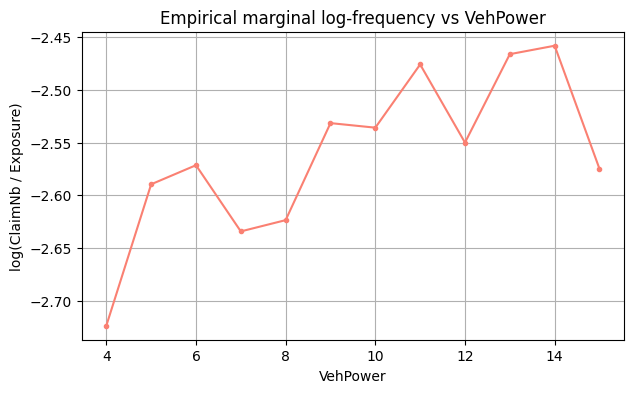

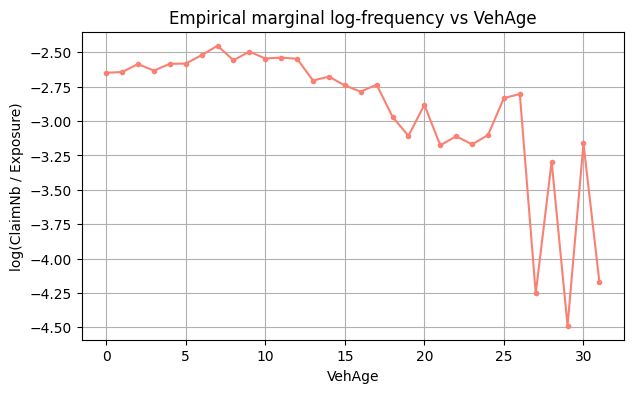

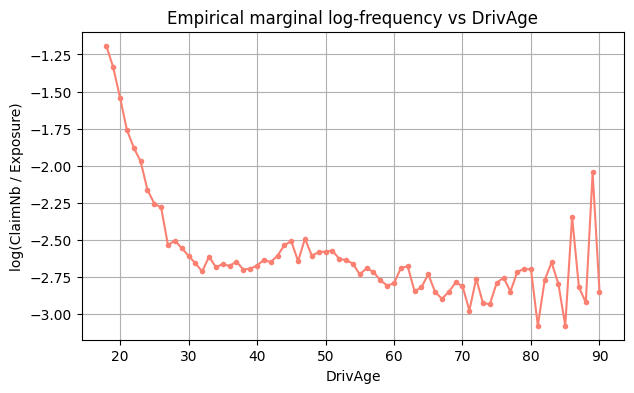

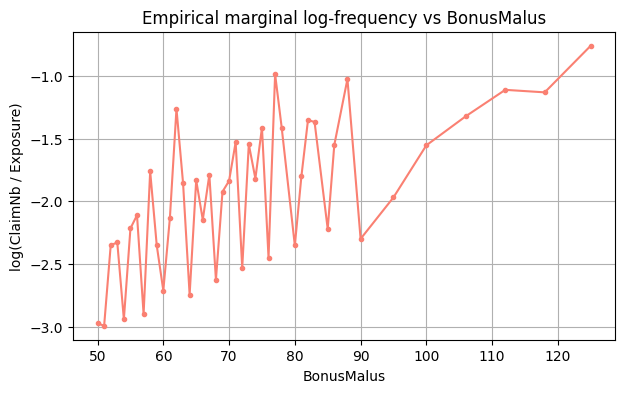

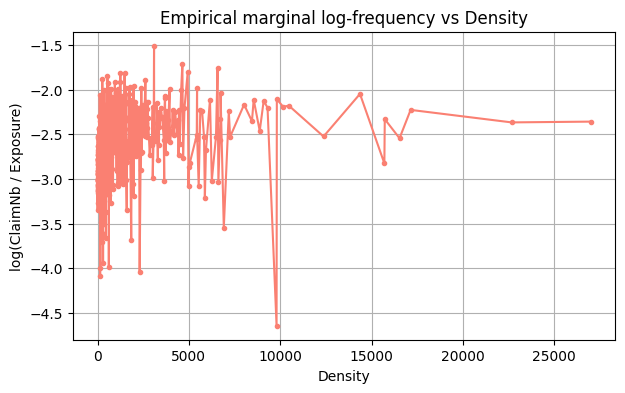

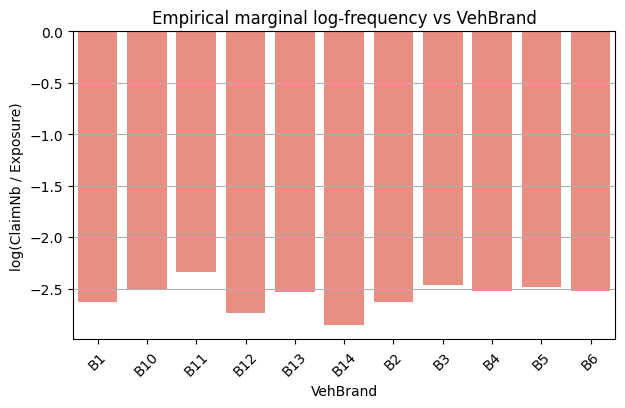

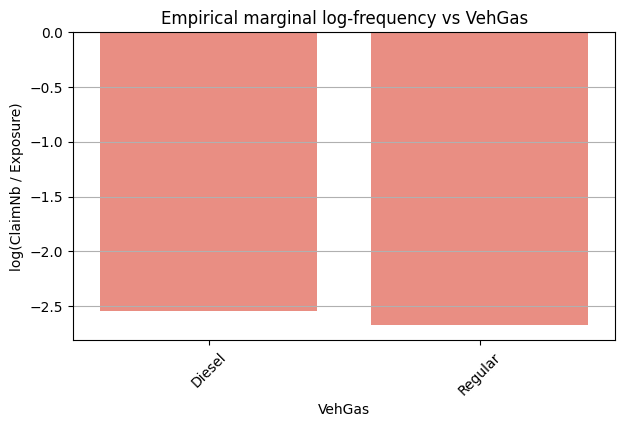

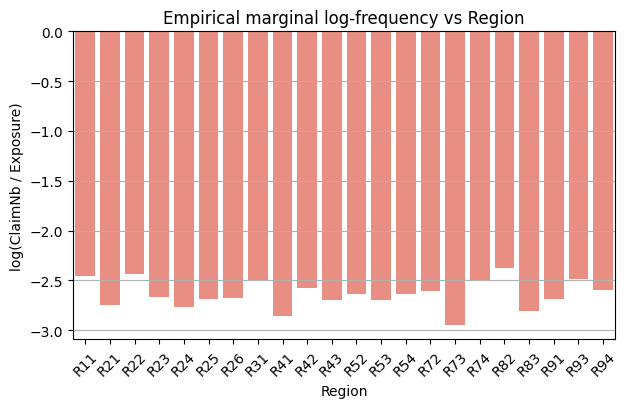

In [4]:
# We work on the raw data (no standardization, no one-hot encoding)
# We remove feature values with very small total exposure to ensure stability of empirical estimates 

def empirical_log_frequency(data, feature, claim_col, exposure_col, min_exposure=100):

    # feature values with total exposure below a threshold will be removed just to make the plot better to interpret
    grouped = (data.groupby(feature).agg({claim_col: "sum", exposure_col: "sum"}))
    grouped = grouped[grouped[exposure_col] >= min_exposure]

    # avoid log(0)
    epsilon = 1e-10
    grouped["log_frequency"] = np.log((grouped[claim_col] + epsilon) / (grouped[exposure_col] + epsilon))

    return grouped


for feature in numeric_features:
    log_freq = empirical_log_frequency(data, feature, target, exposure)
    log_freq = log_freq.sort_index()

    plt.figure(figsize=(7, 4))
    plt.plot(log_freq.index,log_freq["log_frequency"],marker=".",linestyle="-", color="salmon")
    plt.xlabel(feature)
    plt.ylabel("log(ClaimNb / Exposure)")
    plt.title(f"Empirical marginal log-frequency vs {feature}")
    plt.grid(True)
    plt.show()


for feature in categorical_features:
    log_freq = empirical_log_frequency(data, feature, target, exposure)
    #log_freq = log_freq.sort_values("log_frequency")

    plt.figure(figsize=(7, 4))
    sns.barplot(x=log_freq.index.astype(str),y=log_freq["log_frequency"], color="salmon")
    plt.xlabel(feature)
    plt.ylabel("log(ClaimNb / Exposure)")
    plt.title(f"Empirical marginal log-frequency vs {feature}")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()

VehPower:
   - Plot observation: Empirical log-frequency increases roughly linearly with vehicle power.
   - Transformation: None

VehAge:
   - Plot observation: No global linear trend; for young vehicles (0-12y) it's nearly flat;
     for intermediate ages (13-24) it decreases but very old vehicles (>26) show unstable estimates.
     This piecewise behavior violates the log-linear assumption of the Poisson GLM.
   - Transformation: Categorize into 'young', 'intermediate', 'old'.

DrivAge:
   - Plot observation: High claim frequency for young drivers, followed by sharp decrease, then almost plateau for older drivers.
   - Transformation: Categorize into age groups again.

BonusMalus:
   - Plot observation: Varies approximately linearly (though a little noisy) but is skewed.
   - Transformation: Apply logarithm.

Density:
   - Plot observation: Noisy and highly skewed, clear non-linear relationship.
   - Transformation: Apply logarithm.

VehBrand:
   - Plot observation: Discrete risk le

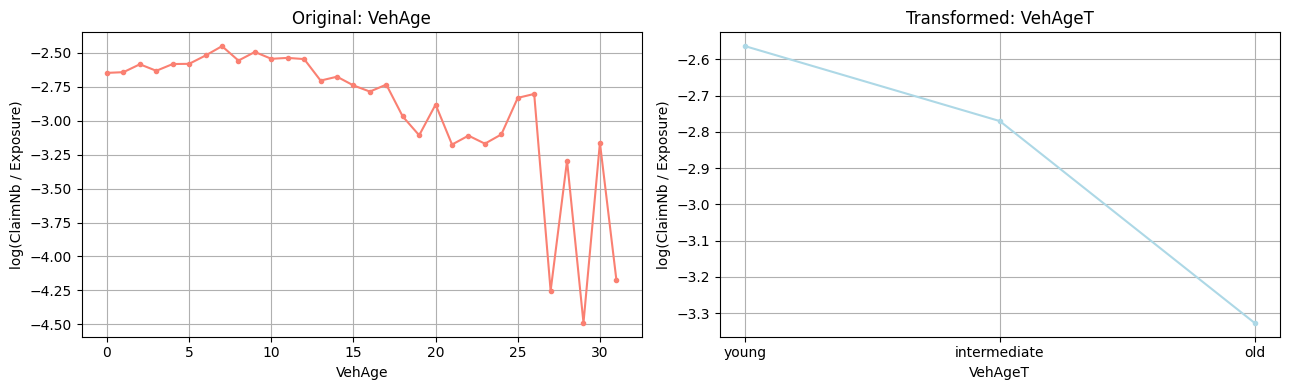

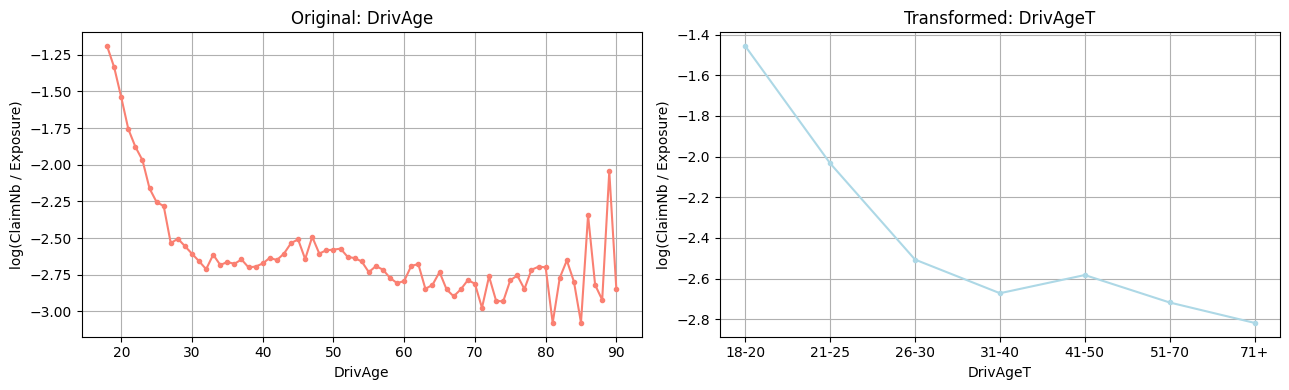

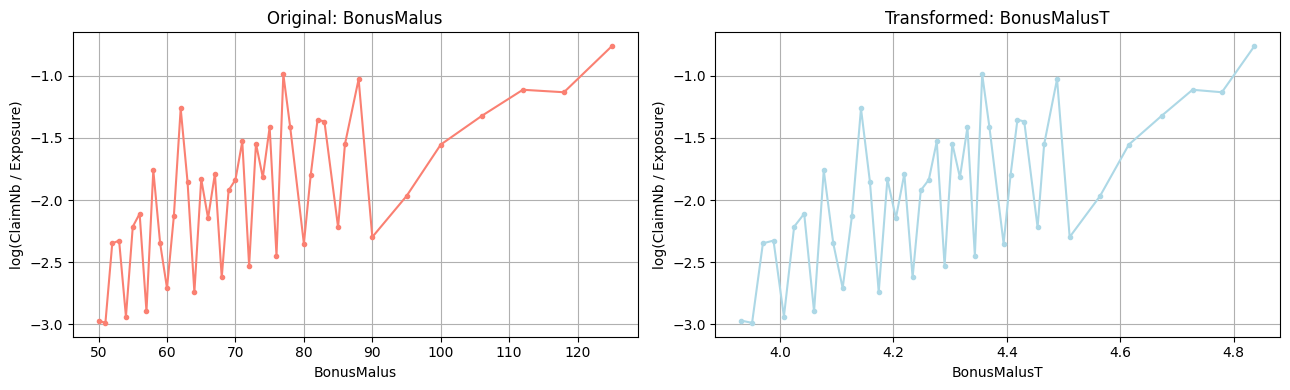

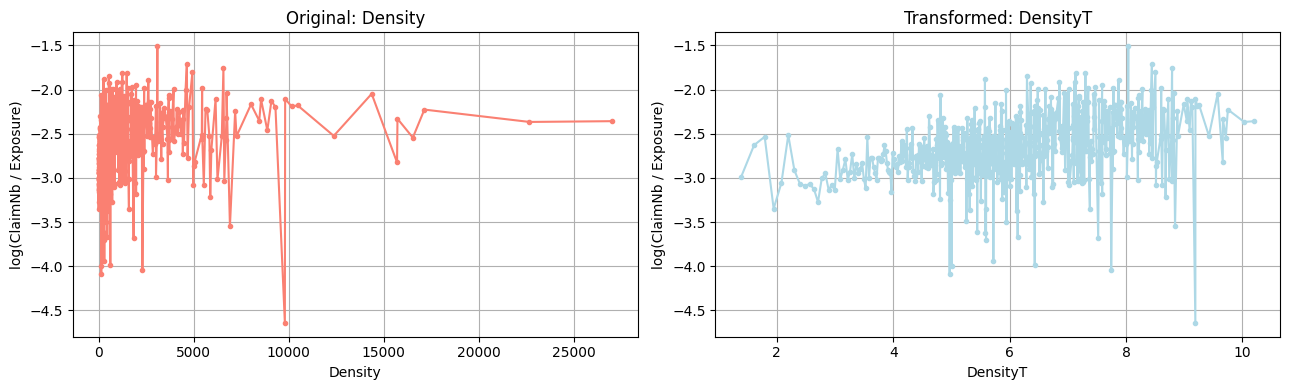

In [5]:
# Propose feature transformations. Justify your choices

print("VehPower:")
print("   - Plot observation: Empirical log-frequency increases roughly linearly with vehicle power.")
print("   - Transformation: None\n")

print("VehAge:")
print("   - Plot observation: No global linear trend; for young vehicles (0-12y) it's nearly flat;")
print("     for intermediate ages (13-24) it decreases but very old vehicles (>26) show unstable estimates.")
print("     This piecewise behavior violates the log-linear assumption of the Poisson GLM.")
print("   - Transformation: Categorize into 'young', 'intermediate', 'old'.\n")

veh_bins = [0, 12, 24, 100]
veh_labels = ["young", "intermediate", "old"]
data["VehAgeT"] = pd.cut(data["VehAge"], bins=veh_bins, labels=veh_labels) 


print("DrivAge:")
print("   - Plot observation: High claim frequency for young drivers, followed by sharp decrease, then almost plateau for older drivers.")
print("   - Transformation: Categorize into age groups again.\n")


driv_bins = [18, 20, 25, 30, 40, 50, 70, 101]
driv_labels = ["18-20","21-25","26-30","31-40","41-50","51-70","71+"]
data["DrivAgeT"] = pd.cut(data["DrivAge"], bins=driv_bins, labels=driv_labels) 

print("BonusMalus:")
print("   - Plot observation: Varies approximately linearly (though a little noisy) but is skewed.")
print("   - Transformation: Apply logarithm.\n")
data["BonusMalusT"] = np.log1p(data["BonusMalus"])



print("Density:")
print("   - Plot observation: Noisy and highly skewed, clear non-linear relationship.")
print("   - Transformation: Apply logarithm.\n")

data["DensityT"] = np.log1p(data["Density"])

print("VehBrand:")
print("   - Plot observation: Discrete risk levels, no natural ordering between brands.")
print("   - Transformation: None\n")

print("VehGas:")
print("   - Plot observation: Binary feature (diesel/regular).")
print("   - Transformation: None\n")

print("Region:")
print("   - Plot observation: Categorical feature representing driver's region.")
print("   - Transformation: None\n")


# plots to visualize that these now have improved linear dependence
feature_pairs = [
    ("VehAge", "VehAgeT"),
    ("DrivAge", "DrivAgeT"),
    ("BonusMalus", "BonusMalusT"),
    ("Density", "DensityT")
]

for original, transformed in feature_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))  # 1 row, 2 columns

    # Original feature
    log_freq_orig = empirical_log_frequency(data, original, target, exposure)
    log_freq_orig = log_freq_orig.sort_index()
    axes[0].plot(log_freq_orig.index, log_freq_orig["log_frequency"], marker=".", linestyle="-", color="salmon")
    axes[0].set_title(f"Original: {original}")
    axes[0].set_xlabel(original)
    axes[0].set_ylabel("log(ClaimNb / Exposure)")
    axes[0].grid(True)

    # Transformed feature
    log_freq_trans = empirical_log_frequency(data, transformed, target, exposure)
    log_freq_trans = log_freq_trans.sort_index()
    axes[1].plot(log_freq_trans.index, log_freq_trans["log_frequency"], marker=".", linestyle="-", color="lightblue")
    axes[1].set_title(f"Transformed: {transformed}")
    axes[1].set_xlabel(transformed)
    axes[1].set_ylabel("log(ClaimNb / Exposure)")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

### Question 1.c

In [6]:
# Train a Poisson GLM using your feature transformations
numeric_features_T = ["VehPower", "BonusMalusT", "DensityT"]
categorical_features_T = ["VehBrand", "VehGas", "Region", "VehAgeT", "DrivAgeT"] #the last two are categorical now

features_T = numeric_features_T + categorical_features_T
target = "ClaimNb"
exposure = "Exposure"

data["Frequency"] = data[target] / data[exposure]

preprocessor_T = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_T),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_T),
    ]
)

X = data[features_T]
y = data["Frequency"]
exposure_data = data[exposure]

X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(X, y, exposure_data, test_size=0.1, random_state=42)


model_T = Pipeline(steps=[("preprocessor", preprocessor_T),("regressor", PoissonRegressor(alpha=0, max_iter=1000))])

model_T.fit( X_train, y_train,regressor__sample_weight=exposure_train)

y_train_pred = model_T.predict(X_train)
y_test_pred = model_T.predict(X_test)

train_mae_old = train_mae
test_mae_old = test_mae
train_mse_old = train_mse
test_mse_old = test_mse
train_loss_old = train_loss
test_loss_old = test_loss

# old results
print("OLD RESULTS FROM 1.a)")

print(f"Train MAE:\t\t {train_mae_old:.4f},\t\tTest MAE:\t\t {test_mae_old:.4f}")
print(f"Train MSE:\t\t {train_mse_old:.4f},\t\tTest MSE:\t\t {test_mse_old:.4f}")
print(f"Train Poisson Deviance:\t {train_loss_old:.4f},\t\tTest Poisson Deviance:\t {test_loss_old:.4f}\n")

train_mae = mean_absolute_error(y_train, y_train_pred, sample_weight=exposure_train)
test_mae = mean_absolute_error(y_test, y_test_pred, sample_weight=exposure_test)

train_mse = mean_squared_error(y_train, y_train_pred, sample_weight=exposure_train)
test_mse = mean_squared_error(y_test, y_test_pred, sample_weight=exposure_test)

train_loss = mean_poisson_deviance(y_train, y_train_pred, sample_weight=exposure_train)
test_loss = mean_poisson_deviance(y_test, y_test_pred, sample_weight=exposure_test)

train_mae_new = train_mae
test_mae_new = test_mae
train_mse_new = train_mse
test_mse_new = test_mse
train_loss_new = train_loss
test_loss_new = test_loss

# Print MAE, MSE and loss on train and test data sets
print("NEW RESULTS WITH FEATURE ENGINEERING")
print(f"Train MAE:\t\t {train_mae:.4f},\t\tTest MAE:\t\t {test_mae:.4f}")
print(f"Train MSE:\t\t {train_mse:.4f},\t\tTest MSE:\t\t {test_mse:.4f}")
print(f"Train Poisson Deviance:\t {train_loss:.4f},\t\tTest Poisson Deviance:\t {test_loss:.4f}\n")

# Make sure your model outperforms the model of Question 1.a
def improvement(old, new):
    return (old-new)/old *100

print("Improvement over original Poisson GLM (Question 1.a):")
#print(f"Train MAE improvement: {improvement(train_mae_old, train_mae_new):.2f}%")
#print(f"Test MAE improvement: {improvement(test_mae_old, test_mae_new):.2f}%")
#print(f"Train MSE improvement: {improvement(train_mse_old, train_mse_new):.2f}%")
#print(f"Test MSE improvement: {improvement(test_mse_old, test_mse_new):.2f}%")
print(f"Train Poisson Deviance improvement: {improvement(train_loss_old, train_loss_new):.2f}%")
print(f"Test Poisson Deviance improvement: {improvement(test_loss_old, test_loss_new):.2f}%")

OLD RESULTS FROM 1.a)
Train MAE:		 0.1383,		Test MAE:		 0.1363
Train MSE:		 0.2356,		Test MSE:		 0.2553
Train Poisson Deviance:	 0.4591,		Test Poisson Deviance:	 0.4507

NEW RESULTS WITH FEATURE ENGINEERING
Train MAE:		 0.1381,		Test MAE:		 0.1361
Train MSE:		 0.2351,		Test MSE:		 0.2547
Train Poisson Deviance:	 0.4566,		Test Poisson Deviance:	 0.4473

Improvement over original Poisson GLM (Question 1.a):
Train Poisson Deviance improvement: 0.56%
Test Poisson Deviance improvement: 0.76%


# Exercise 2 (Poisson FNN)

### Question 2.a

In [7]:
# Neural network implementation
import torch
import torch.nn as nn
import torch.optim as optim

class PoissonNN(nn.Module):
    def __init__(self, input_dim):
        super(PoissonNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return torch.exp(self.net(x))

### Question 2.b

In [17]:
# Train Poisson feedforward neural network model with L2 regularization
from sklearn.model_selection import KFold
from tqdm import tqdm

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features)
    ]
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", DEVICE)

X_train, X_test, y_train, y_test, exposure_train, exposure_test =  X_train_1, X_test_1, y_train_1, y_test_1, exposure_train_1, exposure_test_1

X_train_np = preprocessor.fit_transform(X_train)
X_test_np = preprocessor.transform(X_test)
# Tensors
X_train_torch = torch.tensor(X_train_np, dtype=torch.float32, device=DEVICE)
X_test_torch = torch.tensor(X_test_np, dtype=torch.float32, device=DEVICE)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32, device=DEVICE).view(-1, 1)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32, device=DEVICE).view(-1, 1)
exposure_train_torch = torch.tensor(exposure_train.values, dtype=torch.float32, device=DEVICE).view(-1, 1)
exposure_test_torch = torch.tensor(exposure_test.values, dtype=torch.float32, device=DEVICE).view(-1, 1)

def poisson_deviance_loss(y, y_hat, exposure):
    eps = 1e-10  # to avoid log(0)
    dev = 2 * exposure * (y_hat - y - y*torch.log((y_hat+eps)/(y+eps)))
    return dev.sum()/exposure.sum()

# use cross-validation for L2 regularization selection
weight_decays = [0.0, 1e-5, 1e-4, 1e-3]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_decay = None
best_val_loss = float('inf')
# hyperparameters
batch_size = 10000

for wd in weight_decays:
    val_losses = []
    fold_num = 1
    
    for train_idx, val_idx in kf.split(X_train_np):
        # convert the fold indices to LongTensors on DEVICE for safe indexing of CUDA tensors
        train_idx_t = torch.as_tensor(train_idx, dtype=torch.long, device=DEVICE)
        val_idx_t = torch.as_tensor(val_idx, dtype=torch.long, device=DEVICE)
        
        X_tr = X_train_torch[train_idx_t]
        y_tr = y_train_torch[train_idx_t]
        exp_tr = exposure_train_torch[train_idx_t]

        X_val = X_train_torch[val_idx_t]
        y_val = y_train_torch[val_idx_t]
        exp_val = exposure_train_torch[val_idx_t]

        model = PoissonNN(X_train_np.shape[1]).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=wd)

        loop = tqdm(range(50), desc=f"Weight_decay={wd}, Fold={fold_num}", leave=False)
        for epoch in loop:
            perm = torch.randperm(X_tr.size(0), device=DEVICE)
            for i in range(0, X_tr.size(0), batch_size):
                idx = perm[i:i+batch_size]
                X_batch, y_batch, exp_batch = X_tr[idx], y_tr[idx], exp_tr[idx]
                optimizer.zero_grad()
                y_hat = model(X_batch)
                loss = poisson_deviance_loss(y_batch,y_hat,exp_batch)
                loss.backward()
                optimizer.step()
            #if (epoch + 1) % 1000 == 0:
                #print(f"Weight_decay={wd}, Fold={fold_num}, Epoch {epoch+1}/{batch_size}, CV batch training in progress...")

        with torch.no_grad():
            y_val_hat = model(X_val)
            val_loss = poisson_deviance_loss(y_val, y_val_hat, exp_val).item()
            val_losses.append(val_loss)
            # progress bar not defined here; commented out to avoid NameError
            # loop.set_postfix(val_loss=val_loss)
        #print(f"Weight_decay={wd}, Fold={fold_num} completed, validation Poisson deviance={val_loss:.4f}")
        fold_num += 1

    avg_val_loss = np.mean(val_losses)
    #print(f"L2 weight_decay={wd}, avg val Poisson deviance={avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_decay = wd

print(f"Selected weight_decay={best_decay} by cross-validation\n")

# Train final model with selected weight decay
model_nn = PoissonNN(X_train_np.shape[1]).to(DEVICE)
optimizer = optim.Adam(model_nn.parameters(), lr=0.01, weight_decay=1e-4)

n_epochs = 100
batch_size = 10000

for epoch in range(n_epochs):
    perm = torch.randperm(X_train_torch.size(0))
    for i in range(0, X_train_torch.size(0), batch_size):
        idx = perm[i:i + batch_size]
        X_batch = X_train_torch[idx]
        y_batch = y_train_torch[idx]
        exp_batch = exposure_train_torch[idx]

        optimizer.zero_grad()
        y_hat = model_nn(X_batch)
        loss = poisson_deviance_loss(y_batch,y_hat,exp_batch)
        loss.backward()
        optimizer.step()


with torch.no_grad():
    y_train_pred_nn = model_nn(X_train_torch).cpu().numpy().flatten()
    y_test_pred_nn = model_nn(X_test_torch).cpu().numpy().flatten()


# Print MAE, MSE and loss on train and test data sets
train_mae_nn = mean_absolute_error(y_train, y_train_pred_nn, sample_weight=exposure_train)
test_mae_nn = mean_absolute_error(y_test, y_test_pred_nn, sample_weight=exposure_test)

train_mse_nn = mean_squared_error(y_train, y_train_pred_nn, sample_weight=exposure_train)
test_mse_nn = mean_squared_error(y_test, y_test_pred_nn, sample_weight=exposure_test)

train_loss_nn = mean_poisson_deviance(y_train, y_train_pred_nn, sample_weight=exposure_train)
test_loss_nn = mean_poisson_deviance(y_test, y_test_pred_nn, sample_weight=exposure_test)

print("POISSON NEURAL NETWORK RESULTS")
print(f"Train MAE:\t\t {train_mae_nn:.4f},\t\tTest MAE:\t\t {test_mae_nn:.4f}")
print(f"Train MSE:\t\t {train_mse_nn:.4f},\t\tTest MSE:\t\t {test_mse_nn:.4f}")
print(f"Train Poisson Deviance:\t {train_loss_nn:.4f},\t\tTest Poisson Deviance:\t {test_loss_nn:.4f}\n")


# Make sure your model outperforms the Poisson GLM model of Question 1.b.
print("OLD RESULTS FROM 1.c)")
print(f"Train MAE:\t\t {train_mae:.4f},\t\tTest MAE:\t\t {test_mae:.4f}")
print(f"Train MSE:\t\t {train_mse:.4f},\t\tTest MSE:\t\t {test_mse:.4f}")
print(f"Train Poisson Deviance:\t {train_loss:.4f},\t\tTest Poisson Deviance:\t {test_loss:.4f}\n")

print("Improvement over Poisson GLM (Question 1.c):")
print(f"Train Poisson Deviance improvement: {improvement(train_loss, train_loss_nn):.2f}%")
print(f"Test Poisson Deviance improvement: {improvement(test_loss, test_loss_nn):.2f}%")


print(
"\nWe select the L2 regularization strength (weight_decay) using cross-validation. \n"
"By splitting the training data into 5 folds, we measured how different values of weight_decay \n"

"affected the exposure-weighted Poisson deviance on held-out folds. \n"

"The value that minimized the average validation deviance was chosen.")

using device: cuda


Selected weight_decay=0.0001 by cross-validation

POISSON NEURAL NETWORK RESULTS
Train MAE:		 0.1328,		Test MAE:		 0.1307
Train MSE:		 0.2343,		Test MSE:		 0.2540
Train Poisson Deviance:	 0.4506,		Test Poisson Deviance:	 0.4417

OLD RESULTS FROM 1.c)
Train MAE:		 0.1381,		Test MAE:		 0.1361
Train MSE:		 0.2351,		Test MSE:		 0.2547
Train Poisson Deviance:	 0.4566,		Test Poisson Deviance:	 0.4473

Improvement over Poisson GLM (Question 1.c):
Train Poisson Deviance improvement: 1.31%
Test Poisson Deviance improvement: 1.25%

We select the L2 regularization strength (weight_decay) using cross-validation. 
By splitting the training data into 5 folds, we measured how different values of weight_decay 
affected the exposure-weighted Poisson deviance on held-out folds. 
The value that minimized the average validation deviance was chosen.


In [ ]:
# Train Poisson feedforward neural network model wit L1  regularization selection
("using device:", DEVICE)

# use cross-validation for L1 regularization selection
lambdas = [1.0, 0.0, 0.1, 0.01, 0.001]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_l1 = None
best_val_loss = float('inf')
# hyperparameters
batch_size = 10000

for lam1 in lambdas:
    val_losses = []
    fold_num = 1
    
    for train_idx, val_idx in kf.split(X_train_np):
        # convert the fold indices to LongTensors on DEVICE for safe indexing of CUDA tensors
        train_idx_t = torch.as_tensor(train_idx, dtype=torch.long, device=DEVICE)
        val_idx_t = torch.as_tensor(val_idx, dtype=torch.long, device=DEVICE)
        
        X_tr = X_train_torch[train_idx_t]
        y_tr = y_train_torch[train_idx_t]
        exp_tr = exposure_train_torch[train_idx_t]

        X_val = X_train_torch[val_idx_t]
        y_val = y_train_torch[val_idx_t]
        exp_val = exposure_train_torch[val_idx_t]

        model = PoissonNN(X_train_np.shape[1]).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

        loop = tqdm(range(50), desc=f"l1 regularizer={lam1}, Fold={fold_num}", leave=False)
        for epoch in loop:
            perm = torch.randperm(X_tr.size(0), device=DEVICE)
            for i in range(0, X_tr.size(0), batch_size):
                idx = perm[i:i+batch_size]
                X_batch, y_batch, exp_batch = X_tr[idx], y_tr[idx], exp_tr[idx]
                optimizer.zero_grad()
                y_hat = model(X_batch)
                loss = poisson_deviance_loss(y_batch,y_hat,exp_batch) + lam1 * sum(p.abs().sum() for p in model.parameters())
                loss.backward()
                optimizer.step()
            #if (epoch + 1) % 1000 == 0:
                #print(f"Weight_decay={wd}, Fold={fold_num}, Epoch {epoch+1}/{batch_size}, CV batch training in progress...")

        with torch.no_grad():
            y_val_hat = model(X_val)
            val_loss = poisson_deviance_loss(y_val, y_val_hat, exp_val).item()
            val_losses.append(val_loss)
            # progress bar not defined here; commented out to avoid NameError
            # loop.set_postfix(val_loss=val_loss)
        #print(f"Weight_decay={wd}, Fold={fold_num} completed, validation Poisson deviance={val_loss:.4f}")
        fold_num += 1

    avg_val_loss = np.mean(val_losses)
    #print(f"L2 weight_decay={wd}, avg val Poisson deviance={avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_l1 = lam1

print(f"Selected l1 normalization={best_l1} by cross-validation\n")

# Train final model with selected weight decay
model_nn = PoissonNN(X_train_np.shape[1]).to(DEVICE)
optimizer = optim.Adam(model_nn.parameters(), lr=0.01, weight_decay=0.0)

n_epochs = 100
batch_size = 10000

for epoch in range(n_epochs):
    perm = torch.randperm(X_train_torch.size(0))
    for i in range(0, X_train_torch.size(0), batch_size):
        idx = perm[i:i + batch_size]
        X_batch = X_train_torch[idx]
        y_batch = y_train_torch[idx]
        exp_batch = exposure_train_torch[idx]

        optimizer.zero_grad()
        y_hat = model_nn(X_batch)
        loss = poisson_deviance_loss(y_batch,y_hat,exp_batch) + best_l1 * sum(p.abs().sum() for p in model.parameters())
        loss.backward()
        optimizer.step()


with torch.no_grad():
    y_train_pred_nn = model_nn(X_train_torch).cpu().numpy().flatten()
    y_test_pred_nn = model_nn(X_test_torch).cpu().numpy().flatten()


# Print MAE, MSE and loss on train and test data sets
train_mae_nn = mean_absolute_error(y_train, y_train_pred_nn, sample_weight=exposure_train)
test_mae_nn = mean_absolute_error(y_test, y_test_pred_nn, sample_weight=exposure_test)

train_mse_nn = mean_squared_error(y_train, y_train_pred_nn, sample_weight=exposure_train)
test_mse_nn = mean_squared_error(y_test, y_test_pred_nn, sample_weight=exposure_test)

train_loss_nn = mean_poisson_deviance(y_train, y_train_pred_nn, sample_weight=exposure_train)
test_loss_nn = mean_poisson_deviance(y_test, y_test_pred_nn, sample_weight=exposure_test)

print("POISSON NEURAL NETWORK RESULTS")
print(f"Train MAE:\t\t {train_mae_nn:.4f},\t\tTest MAE:\t\t {test_mae_nn:.4f}")
print(f"Train MSE:\t\t {train_mse_nn:.4f},\t\tTest MSE:\t\t {test_mse_nn:.4f}")
print(f"Train Poisson Deviance:\t {train_loss_nn:.4f},\t\tTest Poisson Deviance:\t {test_loss_nn:.4f}\n")


# Make sure your model outperforms the Poisson GLM model of Question 1.b.
print("OLD RESULTS FROM 1.c)")
print(f"Train MAE:\t\t {train_mae:.4f},\t\tTest MAE:\t\t {test_mae:.4f}")
print(f"Train MSE:\t\t {train_mse:.4f},\t\tTest MSE:\t\t {test_mse:.4f}")
print(f"Train Poisson Deviance:\t {train_loss:.4f},\t\tTest Poisson Deviance:\t {test_loss:.4f}\n")

print("Improvement over Poisson GLM (Question 1.c):")
print(f"Train Poisson Deviance improvement: {improvement(train_loss, train_loss_nn):.2f}%")
print(f"Test Poisson Deviance improvement: {improvement(test_loss, test_loss_nn):.2f}%")


print(
"\nWe select the L2 regularization strength (weight_decay) using cross-validation. \n"
"By splitting the training data into 5 folds, we measured how different values of weight_decay \n"

"affected the exposure-weighted Poisson deviance on held-out folds. \n"

"The value that minimized the average validation deviance was chosen. (L2 regularizer with wd = 0.0001  outperformed L1 regularizer.)")

Selected l1 normalization=0.0 by cross-validation

POISSON NEURAL NETWORK RESULTS
Train MAE:		 0.1354,		Test MAE:		 0.1336
Train MSE:		 0.2343,		Test MSE:		 0.2547
Train Poisson Deviance:	 0.4497,		Test Poisson Deviance:	 0.4448

OLD RESULTS FROM 1.c)
Train MAE:		 0.1381,		Test MAE:		 0.1361
Train MSE:		 0.2351,		Test MSE:		 0.2547
Train Poisson Deviance:	 0.4566,		Test Poisson Deviance:	 0.4473

Improvement over Poisson GLM (Question 1.c):
Train Poisson Deviance improvement: 1.50%
Test Poisson Deviance improvement: 0.55%

We select the L2 regularization strength (weight_decay) using cross-validation. 
By splitting the training data into 5 folds, we measured how different values of weight_decay 
affected the exposure-weighted Poisson deviance on held-out folds. 
The value that minimized the average validation deviance was chosen.


In [ ]:
# Re-evaluate: reuse GLM (model_T) and retrain only NN across 10 random splits
N_SPLITS = 10
results_glm = {"mae": [], "mare": [], "poisson": []}
results_nn = {"mae": [], "mare": [], "poisson": []}

X_all = data[features_T]
y_all = data["Frequency"]
exposure_all = data["Exposure"]

for seed in range(N_SPLITS):
    X_tr, X_te, y_tr, y_te, exp_tr, exp_te = train_test_split(X_all, y_all, exposure_all, test_size=0.1, random_state=seed)

    # Reuse model_T (trained previously in 1.c)
    y_te_pred_glm = model_T.predict(X_te)
    mae_glm = mean_absolute_error(y_te, y_te_pred_glm, sample_weight=exp_te)
    mare_glm = np.average(np.abs((y_te - y_te_pred_glm) / (y_te + 1e-10)), weights=exp_te)
    pois_glm = mean_poisson_deviance(y_te, y_te_pred_glm, sample_weight=exp_te)

    results_glm["mae"].append(mae_glm)
    results_glm["mare"].append(mare_glm)
    results_glm["poisson"].append(pois_glm)

    # retrain NN on this split
    X_tr_np = preprocessor_T.fit_transform(X_tr)
    X_te_np = preprocessor_T.transform(X_te)

    # ColumnTransformer / OneHotEncoder may return scipy sparse matrices.
    # Convert to dense arrays for PyTorch tensors to avoid TypeError.
    if hasattr(X_tr_np, "toarray"):
        X_tr_np = X_tr_np.toarray()
    if hasattr(X_te_np, "toarray"):
        X_te_np = X_te_np.toarray()

    X_tr_t = torch.tensor(np.asarray(X_tr_np), dtype=torch.float32, device=DEVICE)
    X_te_t = torch.tensor(np.asarray(X_te_np), dtype=torch.float32, device=DEVICE)
    y_tr_t = torch.tensor(y_tr.values, dtype=torch.float32, device=DEVICE).view(-1, 1)
    exp_tr_t = torch.tensor(exp_tr.values, dtype=torch.float32, device=DEVICE).view(-1, 1)

    model = PoissonNN(X_tr_np.shape[1]).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    n_epochs = 100
    batch_size = 10000
    model.train()
    loop = tqdm(range(n_epochs))
    for epoch in loop:
        perm = torch.randperm(X_tr_t.size(0), device=DEVICE)
        for i in range(0, X_tr_t.size(0), batch_size):
            idx = perm[i : i + batch_size]
            X_batch, y_batch, exp_batch = X_tr_t[idx], y_tr_t[idx], exp_tr_t[idx]
            optimizer.zero_grad()
            y_hat = model(X_batch)
            loss = poisson_deviance_loss(y_batch, y_hat, exp_batch)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        y_te_pred_nn = model(X_te_t).cpu().numpy().flatten()

    pois_nn = mean_poisson_deviance(y_te, y_te_pred_nn, sample_weight=exp_te)
    results_nn["poisson"].append(pois_nn)

summary_glm = {k: (np.mean(v), np.std(v)) for k, v in results_glm.items()}
summary_nn = {k: (np.mean(v), np.std(v)) for k, v in results_nn.items()}

print("RE-RUN: Reuse GLM (model_T) — retrain only NN (10 splits)")
print("GLM (reuse model_T):")
print(f" Poisson Deviance: {summary_glm['poisson'][0]:.6f} ± {summary_glm['poisson'][1]:.6f}\n")
print("NN (retrained each split):")
print(f" Poisson Deviance: {summary_nn['poisson'][0]:.6f} ± {summary_nn['poisson'][1]:.6f}\n")

def improvement(old, new):
    return (old - new) / old * 100

print("Improvement of NN over GLM (test set average):")
print(f" MAE improvement: {improvement(summary_glm['mae'][0], summary_nn['mae'][0]):.2f}%")
print(f" MARE improvement: {improvement(summary_glm['mare'][0], summary_nn['mare'][0]):.2f}%")
print(f" Poisson Deviance improvement: {improvement(summary_glm['poisson'][0], summary_nn['poisson'][0]):.2f}%")


100%|██████████| 100/100 [00:07<00:00, 12.64it/s]

RE-RUN: Reuse GLM (model_T) — retrain only NN (10 splits)
GLM (reuse model_T):
 MAE: 0.137706 ± 0.001008
 MARE: 691274911.007705 ± 1727908.057001
 Poisson Deviance: 0.455557 ± 0.005647

NN (retrained each split):
 MAE: 0.137330 ± 0.005534
 MARE: 690913616.693666 ± 57468873.909883
 Poisson Deviance: 0.452616 ± 0.005329

Improvement of NN over GLM (test set average):
 MAE improvement: 0.27%
 MARE improvement: 0.05%
 Poisson Deviance improvement: 0.65%


In [34]:
# Paired one-sided t-test on Poisson Deviance (paired across the same splits)
from scipy import stats
alpha = 0.025
glm_pd = np.array(results_glm["poisson"])  # GLM Poisson Deviances per split
nn_pd = np.array(results_nn["poisson"])    # NN Poisson Deviances per split

# Paired t-test (H0: mean(nn_pd - glm_pd) == 0 vs H1: mean(nn_pd - glm_pd) < 0)
# We obtain the two-sided t-stat and p-value, then compute the one-sided p-value for H1: mean < 0
t_stat, p_two_sided = stats.ttest_rel(nn_pd, glm_pd)
df = len(nn_pd) - 1
# one-sided p-value for alternative mean < 0
p_one_sided = stats.t.cdf(t_stat, df)

mean_diff = np.mean(nn_pd - glm_pd)
sd_diff = np.std(nn_pd - glm_pd, ddof=1)
se = sd_diff / np.sqrt(len(nn_pd))
# two-sided 95% CI for mean difference
t_crit = stats.t.ppf(1 - alpha/2, df)
ci_low = mean_diff - t_crit * se
ci_high = mean_diff + t_crit * se

print("\nPaired one-sided t-test (NN - GLM) on Poisson Deviance:")
print(f" t-statistic = {t_stat:.4f}, two-sided p-value = {p_two_sided:.6f}, one-sided p-value (H1: NN < GLM) = {p_one_sided:.6f}")
print(f" Mean difference (NN - GLM) = {mean_diff:.6e} (95% CI: [{ci_low:.6e}, {ci_high:.6e}])")
if p_one_sided < alpha:
    print(f"Result: one-sided p < {alpha:.3f} → Reject H0 in favor of H1: NN Poisson deviance < GLM at {alpha*100:.0f}% level.")
else:
    print(f"Result: one-sided p >= {alpha:.3f} → Fail to reject H0; insufficient evidence NN Poisson deviance < GLM at {alpha*100:.2f}% level.")


Paired one-sided t-test (NN - GLM) on Poisson Deviance:
 t-statistic = -9.5785, two-sided p-value = 0.000005, one-sided p-value (H1: NN < GLM) = 0.000003
 Mean difference (NN - GLM) = -2.940457e-03 (95% CI: [-3.764717e-03, -2.116196e-03])
Result: one-sided p < 0.025 → Reject H0 in favor of H1: NN Poisson deviance < GLM at 2% level.


We can observe that our improvement seems to be statistically significant

# Exercise 3 (Tree-based methods)

### Question 3.a

In [9]:
# Implement a regression tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features)
    ]
)

X_train_tree = preprocessor_tree.fit_transform(X_train)
X_test_tree = preprocessor_tree.transform(X_test)

# Cross-validation
param_grid = {"min_impurity_decrease": [0.0, 0.0001, 0.0005, 0.001, 0.005]}

tree = DecisionTreeRegressor(random_state=42)
cv_tree = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_poisson_deviance', n_jobs=-1)
cv_tree.fit(X_train_tree, y_train, **{"sample_weight": exposure_train})

best_tree = cv_tree.best_estimator_
y_train_pred_tree = best_tree.predict(X_train_tree)
y_test_pred_tree = best_tree.predict(X_test_tree)

# Print MAE, MSE and loss on train and test data sets
train_mae_tree = mean_absolute_error(y_train, y_train_pred_tree, sample_weight=exposure_train)
test_mae_tree = mean_absolute_error(y_test, y_test_pred_tree, sample_weight=exposure_test)

train_mse_tree = mean_squared_error(y_train, y_train_pred_tree, sample_weight=exposure_train)
test_mse_tree = mean_squared_error(y_test, y_test_pred_tree, sample_weight=exposure_test)

train_loss_tree = mean_poisson_deviance(y_train, y_train_pred_tree, sample_weight=exposure_train)
test_loss_tree = mean_poisson_deviance(y_test, y_test_pred_tree, sample_weight=exposure_test)

print("REGRESSION TREE RESULTS")
print(f"Train MAE:\t\t {train_mae_tree:.4f}, \t\tTest MAE:\t\t {test_mae_tree:.4f}")
print(f"Train MSE:\t\t {train_mse_tree:.4f}, \t\tTest MSE:\t\t {test_mse_tree:.4f}")
print(f"Train Poisson Deviance:\t {train_loss_tree:.4f}, \t\tTest Poisson Deviance:\t {test_loss_tree:.4f}\n")

REGRESSION TREE RESULTS
Train MAE:		 0.1381, 		Test MAE:		 0.1358
Train MSE:		 0.2351, 		Test MSE:		 0.2544
Train Poisson Deviance:	 0.4591, 		Test Poisson Deviance:	 0.4472



### Question 3.b

In [10]:
# Implement a random forest model
from sklearn.ensemble import RandomForestRegressor

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features)
    ]
)

X_train_rf = preprocessor_rf.fit_transform(X_train)
X_test_rf = preprocessor_rf.transform(X_test)


# Cross-validation
param_grid_rf = {"min_impurity_decrease": [0.0, 0.0001, 0.0005],"max_features": ["sqrt", "log2", None]}

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
cv_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_poisson_deviance', n_jobs=-1)
cv_rf.fit(X_train_rf, y_train, sample_weight=exposure_train)

best_rf = cv_rf.best_estimator_
y_train_pred_rf = best_rf.predict(X_train_rf)
y_test_pred_rf = best_rf.predict(X_test_rf)

# Print MAE, MSE and loss on train and test data sets
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf, sample_weight=exposure_train)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf, sample_weight=exposure_test)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf, sample_weight=exposure_train)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf, sample_weight=exposure_test)

train_loss_rf = mean_poisson_deviance(y_train, y_train_pred_rf, sample_weight=exposure_train)
test_loss_rf = mean_poisson_deviance(y_test, y_test_pred_rf, sample_weight=exposure_test)

print("RANDOM FOREST RESULTS")
print(f"Train MAE:\t\t {train_mae_rf:.4f}, \t\tTest MAE:\t\t {test_mae_rf:.4f}")
print(f"Train MSE:\t\t {train_mse_rf:.4f}, \t\tTest MSE:\t\t {test_mse_rf:.4f}")
print(f"Train Poisson Deviance:\t {train_loss_rf:.4f}, \t\tTest Poisson Deviance:\t {test_loss_rf:.4f}\n")

RANDOM FOREST RESULTS
Train MAE:		 0.1382, 		Test MAE:		 0.1360
Train MSE:		 0.2351, 		Test MSE:		 0.2544
Train Poisson Deviance:	 0.4586, 		Test Poisson Deviance:	 0.4471



### Question 3.c

In [11]:
# Implement gradient boosted trees
from sklearn.ensemble import HistGradientBoostingRegressor

preprocessor_gb = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)


# Cross-validation
param_grid = {
    "regressor__learning_rate": [0.01, 0.05, 0.1],
    "regressor__max_iter": [100, 200, 300]
}

hgb = HistGradientBoostingRegressor(
    loss="poisson",
    max_iter=200,
    max_leaf_nodes=128,
    random_state=42
)

pipeline = Pipeline([("preprocessor", preprocessor_gb),("regressor", hgb)])

cv_gb = GridSearchCV(pipeline,param_grid,cv=3,scoring='neg_mean_poisson_deviance',n_jobs=-1)
cv_gb.fit(X_train, y_train, regressor__sample_weight=exposure_train)
best_gb = cv_gb.best_estimator_

y_train_pred_gb = best_gb.predict(X_train)
y_test_pred_gb = best_gb.predict(X_test)


# Print MAE, MSE and loss on train and test data sets
train_mae_gb = mean_absolute_error(y_train, y_train_pred_gb, sample_weight=exposure_train)
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb, sample_weight=exposure_test)

train_mse_gb = mean_squared_error(y_train, y_train_pred_gb, sample_weight=exposure_train)
test_mse_gb = mean_squared_error(y_test, y_test_pred_gb, sample_weight=exposure_test)

train_loss_gb = mean_poisson_deviance(y_train, y_train_pred_gb, sample_weight=exposure_train)
test_loss_gb = mean_poisson_deviance(y_test, y_test_pred_gb, sample_weight=exposure_test)

print("GRADIENT BOOSTED TREES RESULTS")
print(f"Train MAE:\t\t {train_mae_gb:.4f}, \t\tTest MAE:\t\t {test_mae_gb:.4f}")
print(f"Train MSE:\t\t {train_mse_gb:.4f}, \t\tTest MSE:\t\t {test_mse_gb:.4f}")
print(f"Train Poisson Deviance:\t {train_loss_gb:.4f}, \t\tTest Poisson Deviance:\t {test_loss_gb:.4f}")

GRADIENT BOOSTED TREES RESULTS
Train MAE:		 0.1354, 		Test MAE:		 0.1346
Train MSE:		 0.2311, 		Test MSE:		 0.2532
Train Poisson Deviance:	 0.4300, 		Test Poisson Deviance:	 0.4358


### Conclusion

In [25]:
# Summary of all Methods 1-3 in Comparison

metrics_train = {
    "1a_Original GLM": [train_mae_old, train_mse_old, train_loss_old],
    "1b_Feature Eng. GLM": [train_mae, train_mse, train_loss],
    "2_NN": [train_mae_nn, train_mse_nn, train_loss_nn],
    "3a_Regression Tree": [train_mae_tree, train_mse_tree, train_loss_tree],
    "3b_Random Forest": [train_mae_rf, train_mse_rf, train_loss_rf],
    "3c_Gradient Boosted": [train_mae_gb, train_mse_gb, train_loss_gb]
}

metrics_test = {
    "1a_Original GLM": [test_mae_old, test_mse_old, test_loss_old],
    "1b_Feature Eng. GLM": [test_mae, test_mse, test_loss],
    "2_NN": [test_mae_nn, test_mse_nn, test_loss_nn],
    "3a_Regression Tree": [test_mae_tree, test_mse_tree, test_loss_tree],
    "3b_Random Forest": [test_mae_rf, test_mse_rf, test_loss_rf],
    "3c_Gradient Boosted": [test_mae_gb, test_mse_gb, test_loss_gb]
}

rows = ["MAE", "MSE", "Poisson Deviance"]

df_train = pd.DataFrame(metrics_train, index=rows)
df_test = pd.DataFrame(metrics_test, index=rows)

print("TRAIN SET RESULTS")
display(df_train.round(4))

print("\nTEST SET RESULTS")
display(df_test.round(4))


# we treat 1a_Original GLM as baseline to highlight the improvements
poisson_index = 2 
improvement_train_poisson = {}
improvement_test_poisson = {}

for method in metrics_train.keys():
    if method == "1a_Original GLM":
        continue 
    improvement_train_poisson[method] = improvement(
        metrics_train["1a_Original GLM"][poisson_index],
        metrics_train[method][poisson_index]
    )
    improvement_test_poisson[method] = improvement(
        metrics_test["1a_Original GLM"][poisson_index],
        metrics_test[method][poisson_index]
    )

improvement_train_poisson = pd.Series(improvement_train_poisson)
improvement_test_poisson = pd.Series(improvement_test_poisson)

print("TRAIN SET IMPROVEMENT (%) Poisson Deviance over 1a_Original GLM")
display(improvement_train_poisson.round(2))

print("\nTEST SET IMPROVEMENT (%) Poisson Deviance over 1a_Original GLM")
display(improvement_test_poisson.round(2))

print(
"\nWe observe that the Neural Network and Gradient Boosted Trees models perform really well for this insurance claim prediction task. \n"
"However, they also require significantly more computation time and careful fine-tuning of hyperparameters. \n"
"The parameters we chose are not necessarily optimal, and the search grid could be made much finer to potentially improve performance further. \n\n"
"Still, from these results, we can summarize the following insights:\n"
"- Poisson GLM works well if we want a simple, interpretable model with fast training and reasonable performance. Feature engineering improves its accuracy notably.\n"
"- Training Neural Networks is good for capturing complex non-linear relationships and interactions automatically, but at the cost of longer training times and more hyperparameter tuning.\n"
"- Tree-based methods (Regression Trees, Random Forests, Gradient Boosted Trees) offer a flexible and powerful alternative that can naturally handle categorical features and non-linearities.\n"
"- Gradient Boosted Trees provided by far the best performance in our experiments.\n"
)


TRAIN SET RESULTS


,1a_Original GLM,1b_Feature Eng. GLM,2_NN,3a_Regression Tree,3b_Random Forest,3c_Gradient Boosted
MAE,0.1383,0.1381,0.1345,0.1381,0.1382,0.1354
MSE,0.2356,0.2351,0.2343,0.2351,0.2351,0.2311
Poisson Deviance,0.4591,0.4566,0.4504,0.4591,0.4586,0.4300



TEST SET RESULTS


,1a_Original GLM,1b_Feature Eng. GLM,2_NN,3a_Regression Tree,3b_Random Forest,3c_Gradient Boosted
MAE,0.1363,0.1361,0.1324,0.1358,0.1360,0.1346
MSE,0.2553,0.2547,0.2540,0.2544,0.2544,0.2532
Poisson Deviance,0.4507,0.4473,0.4417,0.4472,0.4471,0.4358


TRAIN SET IMPROVEMENT (%) Poisson Deviance over 1a_Original GLM


1b_Feature Eng. GLM    0.56
2_NN                   1.91
3a_Regression Tree     0.00
3b_Random Forest       0.10
3c_Gradient Boosted    6.34
dtype: float64


TEST SET IMPROVEMENT (%) Poisson Deviance over 1a_Original GLM


1b_Feature Eng. GLM    0.76
2_NN                   2.00
3a_Regression Tree     0.77
3b_Random Forest       0.80
3c_Gradient Boosted    3.31
dtype: float64


We observe that the Neural Network and Gradient Boosted Trees models perform really well for this insurance claim prediction task. 
However, they also require significantly more computation time and careful fine-tuning of hyperparameters. 
The parameters we chose are not necessarily optimal, and the search grid could be made much finer to potentially improve performance further. 

Still, from these results, we can summarize the following insights:
- Poisson GLM works well if we want a simple, interpretable model with fast training and reasonable performance. Feature engineering improves its accuracy notably.
- Training Neural Networks is good for capturing complex non-linear relationships and interactions automatically, but at the cost of longer training times and more hyperparameter tuning.
- Tree-based methods (Regression Trees, Random Forests, Gradient Boosted Trees) offer a flexible and powerful alternative that can naturally handle categorical features and non-linearities.
- Grad